# Rotary Coefficients Experiments
# Senior Thesis, Connor Diaz
# Production of Data Files 
### Analysis in Separate Notebook 

In [1]:
### Imports ###

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from rotary_analysis import * # custom library of functions 

In [2]:
# Define data structure (xarray DataArrays and Datasets)to save intermediate data

# Dimensions will be based on station and profile numbers. Stay consistent with Andreas's 
# conventions, e.g. keep cruise names as metadata to the profile numbers. 

# Method experiment will produce same size data as original database

# Time averaging reduces profile number dimension to 1 

# Compute separately, but lump in velocity and shear as vars in final dataset 

data_dir = './original_data_copy/FSDB_SR1b_V0.1_20221013/'

# view data structure of original database

view = xr.open_dataset(data_dir+'R09_LADCP.nc')
view

<xarray.Dataset>
Dimensions:                     (depth_coordinate: 11947, profile_number: 16)
Dimensions without coordinates: depth_coordinate, profile_number
Data variables:
    depth                       (depth_coordinate, profile_number) float64 ...
    height_above_seabed         (depth_coordinate, profile_number) float64 ...
    zonal_velocity              (depth_coordinate, profile_number) float64 ...
    meridional_velocity         (depth_coordinate, profile_number) float64 ...
    downcast_vertical_velocity  (depth_coordinate, profile_number) float64 ...
    upcast_vertical_velocity    (depth_coordinate, profile_number) float64 ...
    cruise_id                   (profile_number) |S20 ...
    date                        (profile_number) |S10 ...
    station_number              (profile_number) float64 ...
    longitude                   (profile_number) float64 ...
    time                        (profile_number) |S8 ...
    latitude                    (profile_number) float64 ...
Attributes:
    DB_version:  0.1

## Show problem with missing cruises

In [3]:
# Demonstration of Dataset Bug, Missing JR17001 CTD data 
# Provides justification for workaround to only use overlapping data. 

stations = ['0'+str(i) for i in range(1,10)] + [str(i) for i in range(10,28)]

prob = []
for station in stations:
    cr1 = list(xr.open_dataset(data_dir+'R'+station+'_LADCP.nc').cruise_id.to_numpy())
    cr2 = list(xr.open_dataset(data_dir+'R'+station+'_CTD.nc').cruise_id.to_numpy())
    if len(cr1) != len(cr2):
        if len(cr1) > len(cr2):
            l = cr2
            r = cr1
        else:
            l = cr1
            r = cr2
            
        print([i for i in r if i not in l], 'does not overlap for LADCP and CTD data for station ', station)
        prob.append(station)
        
print(sorted(prob))

[b'2017_JR17001'] does not overlap for LADCP and CTD data for station  01
[b'2017_JR17001'] does not overlap for LADCP and CTD data for station  02
[b'2017_JR17001'] does not overlap for LADCP and CTD data for station  03
[b'2017_JR17001'] does not overlap for LADCP and CTD data for station  04
[b'2017_JR17001'] does not overlap for LADCP and CTD data for station  06
[b'2017_JR17001'] does not overlap for LADCP and CTD data for station  07
[b'2017_JR17001'] does not overlap for LADCP and CTD data for station  08
[b'2017_JR17001'] does not overlap for LADCP and CTD data for station  10
[b'2017_JR17001'] does not overlap for LADCP and CTD data for station  11
[b'2017_JR17001'] does not overlap for LADCP and CTD data for station  13
[b'2017_JR17001'] does not overlap for LADCP and CTD data for station  14
[b'2017_JR17001'] does not overlap for LADCP and CTD data for station  16
[b'2017_JR17001'] does not overlap for LADCP and CTD data for station  17
[b'2017_JR17001'] does not overlap for

## Check for instances where ctd depth < ladcp depth
### and find deepest velocity grid

In [57]:
deepest_vel_grid = []
deepest_loc = ''

for station in stations:
    # loop over profile numbers, but by dictionary lookup because the profiles do not line up

    # create dictionaries for cruise:profile_number mapping for LADCP and CTD because they don't match up
    ctd = xr.open_dataset(data_dir+'R'+station+'_CTD.nc')
    ladcp = xr.open_dataset(data_dir+'R'+station+'_LADCP.nc')

    ctd_cruise_idx = {}
    ladcp_cruise_idx = {}

    for i,cr in enumerate(ctd.cruise_id.to_numpy()):
        ctd_cruise_idx[cr] = ctd.profile_number.to_numpy()[i]
    for i,cr in enumerate(ladcp.cruise_id.to_numpy()):
        ladcp_cruise_idx[cr] = ladcp.profile_number.to_numpy()[i]

    # loop over CTD cruises, because this is the subset of cruises (JR170001 missing from some CTD data)
    ctd_cruises = ctd.cruise_id.to_numpy()
        
    for cruise in ctd_cruises:
    
        ladcp_profile = ladcp_cruise_idx[cruise]
        ctd_profile   = ctd_cruise_idx[cruise]
        
        ctd_depth = ctd.depth.sel(profile_number=ctd_profile).to_numpy()
        vel_depth = ladcp.depth.sel(profile_number=ladcp_profile).to_numpy()
        
        ctd_depth = ctd_depth[ctd_depth < 8.0E36]
        vel_depth = vel_depth[vel_depth < 8.0E36]
        
        if len(vel_depth) > len(deepest_vel_grid):
            deepest_vel_grid = vel_depth
            deepest_loc = str(station) + ' ' + str(cruise)
        
        if ctd_depth[-1] < vel_depth[-1]:
            print(station)
            print(cruise)
            print(vel_depth[-1] - ctd_depth[-1])
            
        

01
b'2011_JR265'
1.875
02
b'2009_JR195'
0.625
02
b'2011_JR265'
1.875
03
b'2002_JR81'
4.375
03
b'2009_JR195'
3.125
03
b'2018_JR18002'
3.125
04
b'2003_JR94'
20.625
04
b'2004_JR115'
24.375
04
b'2011_JR265'
5.625
04
b'2016_JR16002'
4.375
05
b'2008_JR194'
3.125
06
b'2015_JR306'
0.625
07
b'2003_JR94'
5.625
07
b'2009_JC031'
0.625
07
b'2018_JR18002'
5.625
10
b'2015_JR306'
14.375
10
b'2016_JR15003'
1.875
10
b'2016_JR16002'
0.625
11
b'2003_JR94'
4.375
11
b'2011_JR265'
0.625
11
b'2012_DUK3'
115.625
11
b'2016_JR15003'
0.625
13
b'2003_JR94'
4.375
13
b'2012_DUK3'
0.625
14
b'2015_JR306'
10.625
14
b'2016_JR16002'
0.625
15
b'2008_JR194'
4.375
15
b'2012_DUK3'
5.625
15
b'2015_JR306'
8.125
15
b'2016_JR16002'
1.875
15
b'2018_JR18002'
1.875
16
b'2002_JR81'
18.125
16
b'2003_JR94'
8.125
16
b'2009_JC031'
49.375
16
b'2016_JR16002'
19.375
17
b'2009_JC031'
61.875
17
b'2018_JR18002'
16.875
18
b'2012_DUK3'
19.375
20
b'2011_JR265'
0.625
21
b'2011_JR265'
9.375
21
b'2012_DUK3'
0.625
22
b'2009_JC031'
58.125
22
b'2011_J

In [58]:
deepest_vel_grid

array([   0.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
         45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,
         90.,   95.,  100.,  105.,  110.,  115.,  120.,  125.,  130.,
        135.,  140.,  145.,  150.,  155.,  160.,  165.,  170.,  175.,
        180.,  185.,  190.,  195.,  200.,  205.,  210.,  215.,  220.,
        225.,  230.,  235.,  240.,  245.,  250.,  255.,  260.,  265.,
        270.,  275.,  280.,  285.,  290.,  295.,  300.,  305.,  310.,
        315.,  320.,  325.,  330.,  335.,  340.,  345.,  350.,  355.,
        360.,  365.,  370.,  375.,  380.,  385.,  390.,  395.,  400.,
        405.,  410.,  415.,  420.,  425.,  430.,  435.,  440.,  445.,
        450.,  455.,  460.,  465.,  470.,  475.,  480.,  485.,  490.,
        495.,  500.,  505.,  510.,  515.,  520.,  525.,  530.,  535.,
        540.,  545.,  550.,  555.,  560.,  565.,  570.,  575.,  580.,
        585.,  590.,  595.,  600.,  605.,  610.,  615.,  620.,  625.,
        630.,  635.,

In [6]:
deepest_loc

"20 b'2012_DUK3'"

In [7]:
xr.open_dataset(data_dir+'R20_LADCP.nc').cruise_id

<xarray.DataArray 'cruise_id' (profile_number: 17)>
array([b'2002_JR81', b'2003_JR94', b'2004_JR115', b'2007_JR193', b'2008_JR194',
       b'2009_JC031', b'2009_JR195', b'2011_DUK2.5', b'2011_JR265',
       b'2012_DUK3', b'2013_DUK4', b'2014_DUK5', b'2015_JR306',
       b'2016_JR15003', b'2016_JR16002', b'2017_JR17001', b'2019_DY113'],
      dtype='|S20')
Dimensions without coordinates: profile_number

In [8]:
# find deepest rotary coeff profile grid
# all other grids are subsets of this one
udeep, vdeep, Ndeep, veldeep, ctddeep, cruisedeep = process_data(20, 9, data_dir)
rcveldeep, rcshdeep, rcdepthdeep = rotary_coefficient_profile(150, 320, udeep, vdeep, Ndeep, veldeep, ctddeep)
rcdepthdeep

array([ 310.,  470.,  630.,  790.,  950., 1110., 1270., 1430., 1590.,
       1750., 1910., 2070., 2230., 2390., 2550., 2710., 2870., 3030.,
       3190., 3350., 3510., 3670., 3830., 3990., 4150., 4310., 4470.])

In [9]:
xr.open_dataset(data_dir+'R01_LADCP.nc').profile_number.to_numpy()
for i, cr in enumerate(xr.open_dataset(data_dir+'R01_LADCP.nc').cruise_id.to_numpy()):
    print(i, cr)

0 b'2002_JR81'
1 b'2004_JR115'
2 b'2005_JR139'
3 b'2007_JR193'
4 b'2008_JR194'
5 b'2009_JC031'
6 b'2009_JR195'
7 b'2011_JR265'
8 b'2013_DUK4'
9 b'2015_JR306'
10 b'2016_JR15003'
11 b'2016_JR16002'
12 b'2017_JR17001'
13 b'2018_JR18002'
14 b'2019_DY113'


In [10]:
str(xr.open_dataset(data_dir+'R01_LADCP.nc').cruise_id.to_numpy()[0])[2:-1]

'2002_JR81'

# Produce the initial method data
### Standard Cutoffs, Standard Windowing (320m half-overlapping)
### Shear and Velocity Rotary Coefficient Profile Time Series for Both Methods

In [11]:
test = []

In [12]:
# using default kwargs in rotary coefficient profile function, the default calculations are based on
# ***** buoyancy frequency normalized, spectrally corrected periodogram values *****

 
# create list of station ids 
# loop over stations
stations = ['0'+str(i) for i in range(1,10)] + [str(i) for i in range(10,28)]

for station in stations:
    # loop over profile numbers, but by dictionary lookup because the profiles do not line up

    # create dictionaries for cruise:profile_number mapping for LADCP and CTD because they don't match up
    ctd = xr.open_dataset(data_dir+'R'+station+'_CTD.nc')
    ladcp = xr.open_dataset(data_dir+'R'+station+'_LADCP.nc')

    ctd_cruise_idx = {}
    ladcp_cruise_idx = {}

    for i,cr in enumerate(ctd.cruise_id.to_numpy()):
        ctd_cruise_idx[cr] = ctd.profile_number.to_numpy()[i]
    for i,cr in enumerate(ladcp.cruise_id.to_numpy()):
        ladcp_cruise_idx[cr] = ladcp.profile_number.to_numpy()[i]

    # loop over CTD cruises, because this is the subset of cruises (JR170001 missing from some CTD data)
    ctd_cruises  = ctd.cruise_id.to_numpy()
    cruise_names = [str(c)[2:-1] for c in ctd_cruises]
    
    # create container for station data
    station_data = np.empty((len(ctd_cruises), 2, 2, len(rcdepthdeep)))

    for i, cruise in enumerate(ctd_cruises):
    
        ladcp_profile = ladcp_cruise_idx[cruise]
        ctd_profile   = ctd_cruise_idx[cruise]
        
        if ladcp_profile != ctd_profile:
            workaround=True
        else:
            workaround=False
            
        # get values 
        u,v,N,vel_depth,ctd_depth,cruise_name = process_data(station, ladcp_profile, data_dir=data_dir,workaround=True,ctd_profile_number=ctd_profile)
        
        # compute rotary profiles
        R_c_vel_prof1, R_c_sh_prof1, midp1 = rotary_coefficient_profile(150,320,u,v,N,vel_depth,ctd_depth,method='coeff last')
        R_c_vel_prof2, R_c_sh_prof2, midp2 = rotary_coefficient_profile(150,320,u,v,N,vel_depth,ctd_depth,method='coeff first')
        
        # fill profiles with np.nan to regular grid rcdepthdeep 
        if len(R_c_vel_prof1) < len(rcdepthdeep):
            n_fill = len(rcdepthdeep) - len(R_c_vel_prof1)
            
            R_c_vel_prof1 = np.append(R_c_vel_prof1, np.full(n_fill, np.nan))
            R_c_sh_prof1  = np.append(R_c_sh_prof1, np.full(n_fill, np.nan))
            R_c_vel_prof2 = np.append(R_c_vel_prof2, np.full(n_fill, np.nan))
            R_c_sh_prof2  = np.append(R_c_sh_prof2, np.full(n_fill, np.nan))
            
        # store in data structure 
        station_data[i,0,0,:] = R_c_vel_prof1
        station_data[i,0,1,:] = R_c_sh_prof1
        station_data[i,1,0,:] = R_c_vel_prof2
        station_data[i,1,1,:] = R_c_sh_prof2
        
    # end 
    
    station_da = xr.DataArray(data=station_data,
                              dims=['profile_number', 'coeff_method','variable','depth'],
                              coords={'profile_number':np.arange(len(ctd_cruises)), 
                                   'coeff_method':['coeff_last','coeff_first'],
                                   'variable':['velocity','shear'],
                                   'depth':rcdepthdeep})
    
    # add cruise_names 
    cruises_da = xr.DataArray(data=cruise_names,
                             dims=['profile_number'],
                             coords={'profile_number':np.arange(len(ctd_cruises))}
                             )
    
    station_ds = xr.Dataset(data_vars = {'rotary_coeff':station_da, 'cruise_id':cruises_da})
    
    # add metadata and dataset description
    descr = 'Rotary coefficient profiles resulting from standard windowing in Thurnherr et al. `Summertime Internal-Wave Properties Along the SR1b Section Across Drake Passage` (n.d.) but for the two tested rotary coefficient methods described in `rotary_coefficient`. Profiles of rotary coefficients were produced at each station for each cruise where there is sufficient data. They were calculated for both velocity and shear profiles.'
    
    station_ds.attrs = {'description':descr}
    
    test.append(station_ds)
    
    # save netcdf file of just C_m method experiment
    #station_ds.to_netcdf('./experimental_data/R'+str(station)+'_method_experiment.nc')

In [13]:
test[1].rotary_coeff.sel(coeff_method='coeff_last',variable='shear',profile_number=8)

<xarray.DataArray 'rotary_coeff' (depth: 27)>
array([ 0.33130472, -0.251952  , -0.59643253,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan])
Coordinates:
    profile_number  int64 8
    coeff_method    <U11 'coeff_last'
    variable        <U8 'shear'
  * depth           (depth) float64 310.0 470.0 630.0 ... 4.31e+03 4.47e+03

In [14]:
test[10].cruise_id.sel(profile_number=8).to_numpy()

array('2011_JR265', dtype='<U12')

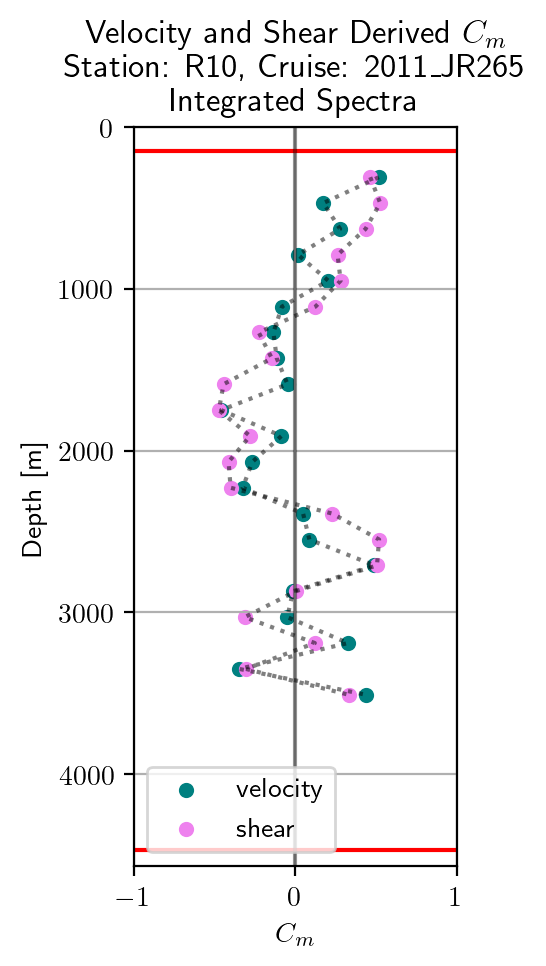

In [15]:
plot_rotary_coeff(test[10].rotary_coeff.sel(coeff_method='coeff_last',variable='velocity',profile_number=8),
                 test[10].rotary_coeff.sel(coeff_method='coeff_last',variable='shear',profile_number=8),
                 test[10].depth,
                 test[10].depth,
                 subtitle='Station: R10, Cruise: 2011_JR265 \n Integrated Spectra')

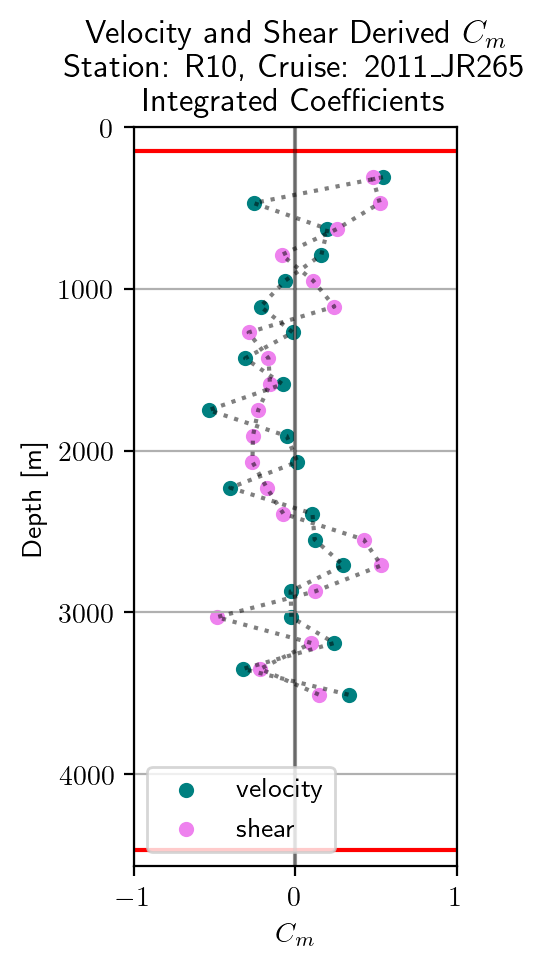

In [16]:
plot_rotary_coeff(test[10].rotary_coeff.sel(coeff_method='coeff_first',variable='velocity',profile_number=8),
                 test[10].rotary_coeff.sel(coeff_method='coeff_first',variable='shear',profile_number=8),
                 test[10].depth,
                 test[10].depth,
                 subtitle='Station: R10, Cruise: 2011_JR265 \n Integrated Coefficients')

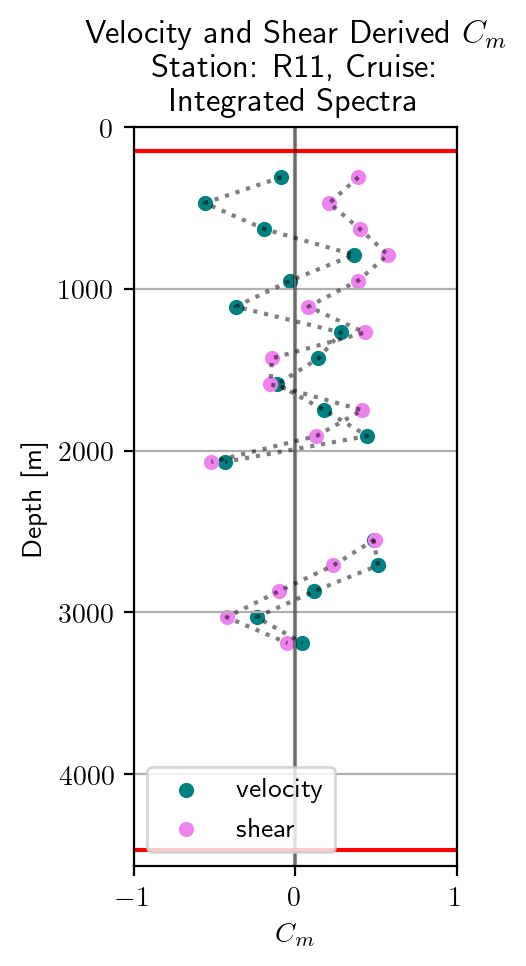

In [17]:
plot_rotary_coeff(test[11].rotary_coeff.sel(coeff_method='coeff_last',variable='velocity',profile_number=8),
                 test[11].rotary_coeff.sel(coeff_method='coeff_last',variable='shear',profile_number=8),
                 test[11].depth,
                 test[11].depth,
                 subtitle='Station: R11, Cruise:  \n Integrated Spectra')

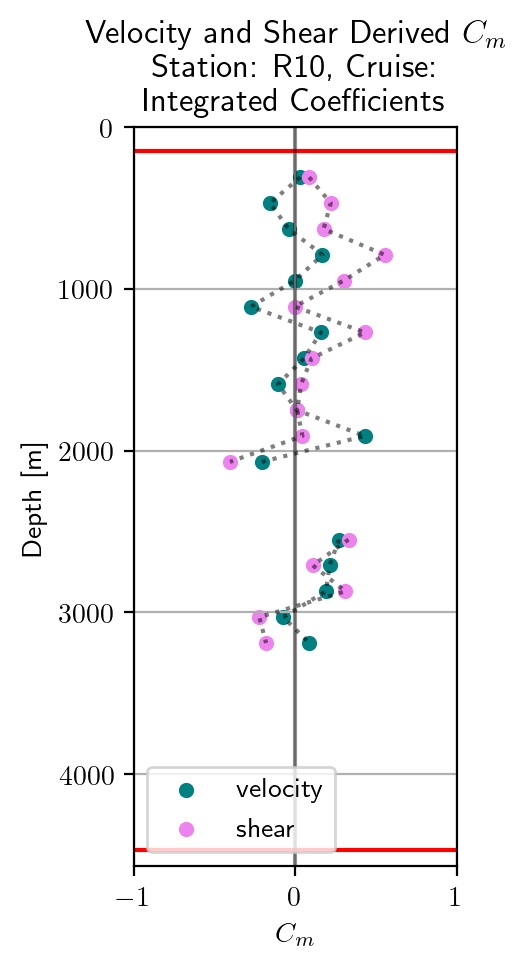

In [18]:
plot_rotary_coeff(test[11].rotary_coeff.sel(coeff_method='coeff_first',variable='velocity',profile_number=8),
                 test[11].rotary_coeff.sel(coeff_method='coeff_first',variable='shear',profile_number=8),
                 test[11].depth,
                 test[11].depth,
                 subtitle='Station: R10, Cruise:  \n Integrated Coefficients')

In [19]:
xr.open_dataset(data_dir+'R13_LADCP.nc').cruise_id

<xarray.DataArray 'cruise_id' (profile_number: 17)>
array([b'2002_JR81', b'2003_JR94', b'2004_JR115', b'2005_JR139', b'2008_JR194',
       b'2009_JC031', b'2011_DUK2.5', b'2011_JR265', b'2012_DUK3',
       b'2013_DUK4', b'2014_DUK5', b'2015_JR306', b'2016_JR15003',
       b'2016_JR16002', b'2017_JR17001', b'2018_JR18002', b'2019_DY113'],
      dtype='|S20')
Dimensions without coordinates: profile_number

In [20]:
xr.open_dataset(data_dir+'R13_CTD.nc').cruise_id

<xarray.DataArray 'cruise_id' (profile_number: 16)>
array([b'2002_JR81', b'2003_JR94', b'2004_JR115', b'2005_JR139', b'2008_JR194',
       b'2009_JC031', b'2011_DUK2.5', b'2011_JR265', b'2012_DUK3',
       b'2013_DUK4', b'2014_DUK5', b'2015_JR306', b'2016_JR15003',
       b'2016_JR16002', b'2018_JR18002', b'2019_DY113'], dtype='|S20')
Dimensions without coordinates: profile_number

# Time average spectra, produce associated data.

### Maybe just write whole profile procedure here instead of rewriting function. 

In [121]:
# figure out array sizes and storage
# need to do deepest grid stuff again to regularize size -- gets around max_n before assignment problem

# parameters
initial_lag_m = 150
window_length_m = 320 
density = False
v_spacing = 5
N_normalize = True
transfer = True
standard_cutoffs = [(2*np.pi)/(60),(2*np.pi)/(180)]

# sizes for shapes
N_data = int(window_length_m / v_spacing)
assert type(N_data) == int, 'series resolution is not an integer'
N_wavenumbers = ((window_length_m / v_spacing) / 2) - 1 # non-zero wavenumbers / 2 - nyquist and zero wavenumbers 

# for each station
stations = ['0'+str(i) for i in range(1,10)] + [str(i) for i in range(10,28)]

for station in stations:
    # for each cruise
    # loop over profile numbers, but by dictionary lookup because the profiles do not line up

    # create dictionaries for cruise:profile_number mapping for LADCP and CTD because they don't match up
    ctd = xr.open_dataset(data_dir+'R'+station+'_CTD.nc')
    ladcp = xr.open_dataset(data_dir+'R'+station+'_LADCP.nc')

    ctd_cruise_idx = {}
    ladcp_cruise_idx = {}

    for i,cr in enumerate(ctd.cruise_id.to_numpy()):
        ctd_cruise_idx[cr] = ctd.profile_number.to_numpy()[i]
    for i,cr in enumerate(ladcp.cruise_id.to_numpy()):
        ladcp_cruise_idx[cr] = ladcp.profile_number.to_numpy()[i]

    # loop over CTD cruises, because this is the subset of cruises (JR170001 missing from some CTD data)
    ctd_cruises  = ctd.cruise_id.to_numpy()
    cruise_names = [str(c)[2:-1] for c in ctd_cruises]
    
    # storage for all cruise spectra 
    # shape -- cruises X deepest window grid X Fourier coefficients / 2 - 2 (half - zero freq - nyquist), 2 (ccw [0] then cw [1]) 
    station_vel_spectra = np.full((len(ctd_cruises), len(rcdepthdeep), int(N_wavenumbers), 2), np.nan)
    station_sh_spectra  = np.full((station_vel_spectra.shape), np.nan)
    
    # variable to count number of cruises average is made from
    n_cruise_data = 0
    
    for i, cruise in enumerate(ctd_cruises):
    
        ladcp_profile = ladcp_cruise_idx[cruise]
        ctd_profile   = ctd_cruise_idx[cruise]
        
        if ladcp_profile != ctd_profile:
            workaround=True
        else:
            workaround=False
            
        # get values 
        u,v,N,vel_depth,ctd_depth,cruise_name = process_data(station, ladcp_profile, data_dir=data_dir,workaround=True,ctd_profile_number=ctd_profile)
        
        # prepare windows 
        max_n = int((vel_depth[-1] - window_length_m)/(window_length_m/2))
        lags  = [initial_lag_m + n*(window_length_m/2) for n in range(max_n)]
        midp  = np.array(lags[1:] + [lags[-1] + window_length_m / 2])
    
        # get shear 
        u_sh,v_sh = shear(u,v)
        
        # window data
        for n in range(max_n):
            try:
                vel_data = window_data(lags[n], window_length_m, u, v, N, vel_depth, ctd_depth, v_spacing)
                shear_data = window_data(lags[n], window_length_m, u_sh, v_sh, N, vel_depth, ctd_depth, v_spacing)
                    
            # catch CTD/LADCP overlap problem described in `window_data`
            except ValueError:
                # fill nans for these spectra 
                print('vel and shear data not found')

                station_vel_spectra[i,n,:,0] = np.nan
                station_vel_spectra[i,n,:,1] = np.nan
                                   
                station_sh_spectra[i,n,:,0] = np.nan
                station_sh_spectra[i,n,:,1] = np.nan 

                continue

            try:
                ccw_vel_spectra, cw_vel_spectra, wn, *vel_rest = \
                rotary_spectra(vel_data[0],vel_data[1],vel_data[2],N_normalize=N_normalize,transfer=transfer,density=density,shear=False)
                
                ccw_shear_spectra, cw_shear_spectra, *sh_rest = \
                rotary_spectra(shear_data[0],shear_data[1],shear_data[2],N_normalize=N_normalize,transfer=transfer,density=density,shear=True)
                # of tuple form (ccw_power, cw_power, ccw_wn, cw_wn, zero_f_power)
                                   
                # fill profiles with np.nan to regular grid rcdepthdeep 
#                 if len(ccw_vel_spectra) < len(rcdepthdeep):
#                     n_fill = len(rcdepthdeep) - len(ccw_vel_spectra)
                                   
#                     ccw_vel_spectra   = np.append(ccw_vel_spectra, np.full(n_fill, np.nan))
#                     cw_vel_spectra    = np.append(cw_vel_spectra, np.full(n_fill, np.nan))
#                     ccw_shear_spectra = np.append(ccw_shear_spectra, np.full(n_fill, np.nan))
#                     cw_shear_spectra  = np.append(cw_shear_spectra, np.full(n_fill, np.nan))
                
                # fill in data 
                station_vel_spectra[i,n,:,0] = ccw_vel_spectra 
                station_vel_spectra[i,n,:,1] = cw_vel_spectra
                                   
                station_sh_spectra[i,n,:,0] = ccw_shear_spectra
                station_sh_spectra[i,n,:,1] = cw_shear_spectra 
                
                n_cruise_data += 1
                
            except (AssertionError, TypeError):
                print('spectra not able to be computed')
#                 ccw_vel_spectra, cw_vel_spectra, wn, *vel_rest = \
#                 rotary_spectra(vel_data[0],vel_data[1],vel_data[2],N_normalize=N_normalize,transfer=transfer,density=density,shear=False)
                
                # fill nans for these spectra if for some reason they don't compute 
                
                station_vel_spectra[i,n,:,0] = np.nan
                station_vel_spectra[i,n,:,1] = np.nan
                                   
                station_sh_spectra[i,n,:,0] = np.nan
                station_sh_spectra[i,n,:,1] = np.nan 
        
    # find station mean spectra over time 
    mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
    mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)

    # calculate rotary coefficients 
                                   
    # storage
    # shape -- rcdepthdeep (deepest grid) X 2 (method)
    vel_Rc = np.empty((len(rcdepthdeep), 2))
    sh_Rc  = np.empty((len(rcdepthdeep), 2))
    
    # loop over depths, calcute rotary coefficient two ways, store 
    for depth in range(len(rcdepthdeep)):
        
        # check for nan arrays of missing spectra 
        if np.all(np.isnan(mean_vel_spectra[depth,:,0])):
            Rc_vel_1 = np.nan
            Rc_vel_2 = np.nan
            
            Rc_sh_1 = np.nan
            Rc_sh_2 = np.nan
            
        else:
            Rc_vel_1 = rotary_coefficient(mean_vel_spectra[depth,:,0],mean_vel_spectra[depth,:,1], wn, standard_cutoffs, density=density,method='coeff last')
            Rc_vel_2 = rotary_coefficient(mean_vel_spectra[depth,:,0],mean_vel_spectra[depth,:,1], wn, standard_cutoffs, density=density,method='coeff first')

            Rc_sh_1 = rotary_coefficient(mean_sh_spectra[depth,:,0],mean_sh_spectra[depth,:,1], wn, standard_cutoffs, density=density,method='coeff last')
            Rc_sh_2 = rotary_coefficient(mean_sh_spectra[depth,:,0],mean_sh_spectra[depth,:,1], wn, standard_cutoffs, density=density,method='coeff first')

        vel_Rc[depth,0] = Rc_vel_1
        vel_Rc[depth,1] = Rc_vel_2
        
        sh_Rc[depth,0] = Rc_sh_1
        sh_Rc[depth,1] = Rc_sh_2                       
    
    # save data 
    # make into DataArrays
                
    vel_Rc_da = xr.DataArray(vel_Rc, coords = {'depth':rcdepthdeep, 'comp_method':['coeff_last','coeff_first']},
                            dims = ['depth','comp_method'], name = 'velocity_derived_Rc')
    sh_Rc_da  = xr.DataArray(sh_Rc, coords = {'depth':rcdepthdeep, 'comp_method':['coeff_last','coeff_first']},
                            dims = ['depth','comp_method'], name = 'shear_derived_Rc')
                                   
    station_save_file = xr.Dataset(data_vars = {'velocity_derived_Rc':vel_Rc_da, 'shear_derived_Rc':sh_Rc_da},
                                  attrs = {'station':'R'+station,
                                           'number of cruises from which average coefficient was calculated':n_cruise_data,
                                           'description':'This dataset includes two variables indicating rotary-coefficients-with-depth for the given station\
                                           computed by producing time-averaged rotary spectra over all the repeat cruises at the given station. Rotary coefficients\
                                           are derived from either velocity or shear profiles, then produced according to `coeff last` or `coeff first`\
                                           methods described in the `rotary_coefficient` function documentation. They are gridded to the deepest grid\
                                           over all stations, and filled with np.nan where no data exist. To get the actual last measurement depth,\
                                           you must retrieve it from processing the station and cruise velocity data with the function `process_data`.'})
    
    station_save_file.to_netcdf('./experimental_data/run_2_time_averaged_spectra_Rc/R'+station+'_time_averaged_spectra_Rc.nc')
    
    
    

/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed


/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra 

/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra 

/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra 

/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra 

/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra 

/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra 

/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra 

/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra 

/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra 

/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra 

/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra 

/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra 

/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra 

/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
vel and shear data not found
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not

/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed


/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed


/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed


/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra not able to be computed
spectra 

/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed
vel and shear data not found
spectra not able to be computed
spectra not able to be computed


/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


spectra not able to be computed


/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mea

spectra not able to be computed


/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:129: RuntimeWarning: Mean of empty slice
  mean_vel_spectra = np.nanmean(station_vel_spectra, axis=0)
/var/folders/bq/6sb89d5s7n1576ql0wl4g4040000gn/T/ipykernel_17281/829644151.py:130: RuntimeWarning: Mean of empty slice
  mean_sh_spectra  = np.nanmean(station_sh_spectra, axis=0)


In [96]:
64/2 - 1

31.0

In [130]:
k = xr.open_dataset('./experimental_data/run_2_time_averaged_spectra_Rc/R01_time_averaged_spectra_Rc.nc')

In [131]:
k

<xarray.Dataset>
Dimensions:              (depth: 27, comp_method: 2)
Coordinates:
  * depth                (depth) float64 310.0 470.0 630.0 ... 4.31e+03 4.47e+03
  * comp_method          (comp_method) object 'coeff_last' 'coeff_first'
Data variables:
    velocity_derived_Rc  (depth, comp_method) float64 ...
    shear_derived_Rc     (depth, comp_method) float64 ...
Attributes:
    station:                                                          R01
    number of cruises from which average coefficient was calculated:  14
    description:                                                      This da...

In [132]:
k.shear_derived_Rc

<xarray.DataArray 'shear_derived_Rc' (depth: 27, comp_method: 2)>
array([[-0.149742, -0.106019],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan]])
Coordinates:
  * depth        (depth) float64 310.0 470.0 630.0 ... 4.31e+03 4.47e+03
  * comp_method  (comp_method) object 'coeff_last' 'coeff_first'